<a href="https://colab.research.google.com/github/groda/big_data/blob/master/Hadoop_Setting_up_Spark_Standalone_on_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://github.com/groda/big_data"><div><img src="https://github.com/groda/big_data/blob/master/logo_bdb.png?raw=true" align=right width="90" alt="Logo Big Data for Beginners"></div></a>
# Install and run Spark in standalone mode

<br>

We are going to install Spark on a single machine (the underlying virtual machine of this notebook) in *standalone mode* (i.e. without any cluster manager such as YARN or Kubernetes, see [cluster manager types supported by Spark](https://spark.apache.org/docs/latest/cluster-overview.html#cluster-manager-types)).

We're following the instructions from: https://spark.apache.org/docs/latest/spark-standalone.html.

Before running this notebook you might have to change the constant `HADOOP_SPARK_URL` (the URL for downloading the Hadoop+Spark distribution).

In [ ]:
# URL for downloading Hadoop and Spark
SPARK_VERSION = "3.5.0"
HADOOP_SPARK_URL = "https://dlcdn.apache.org/spark/spark-" + SPARK_VERSION + \
                   "/spark-" + SPARK_VERSION + "-bin-hadoop3.tgz"
import requests
r = requests.head(HADOOP_SPARK_URL)
if r.status_code >= 200 and r.status_code < 400:
    print(f'✅ {HADOOP_SPARK_URL} was found')
else:
    SPARK_CDN = "https://dlcdn.apache.org/spark/"
    print(f'⚠️ {HADOOP_SPARK_URL} was NOT found. \nFind available Spark version in {SPARK_CDN}')

✅ https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz was found


## Setup Spark

### Set some environment variables

In [ ]:
import os
os.environ['HADOOP_SPARK_URL'] = HADOOP_SPARK_URL
os.environ['SPARK_HOME'] = os.path.join('/content', os.path.splitext(os.path.basename(HADOOP_SPARK_URL))[0])
os.environ['PATH'] = ':'.join([os.path.join(os.environ['SPARK_HOME'], 'bin'), os.environ['PATH']])
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

### Download package and unpack

**Note:** using `--no-clobber` option will prevent `wget` from downloading file if already present.

In [ ]:
!wget --no-clobber $HADOOP_SPARK_URL

--2023-10-22 12:56:11--  https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400395283 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.0-bin-hadoop3.tgz’

spark-3.5.0-bin-had 100%[===================>] 381.85M   151MB/s    in 2.5s    

2023-10-22 12:56:14 (151 MB/s) - ‘spark-3.5.0-bin-hadoop3.tgz’ saved [400395283/400395283]



In [ ]:
!([ -d $(basename $HADOOP_SPARK_URL|sed 's/\.[^.]*$//') ] && echo "Spark folder already exists") || (tar xzf $(basename $HADOOP_SPARK_URL) && echo "Uncompressed")


Uncompressed


The long shell command above calls for an explanation. Let's break it down into its parts:

```
$(basename $HADOOP_SPARK_URL|sed 's/\.[^.]*$//')
```
is used to extract the name of the directory where Spark is located after being downloaded and uncompressed.
The directory name is the last part of the Spark download URL minus the `tgz` extension (`sed` takes care of removing this extension).

In [ ]:
%%bash
# extract the last piece from $HADOOP_SPARK_URL
echo '$HADOOP_SPARK_URL is:' $HADOOP_SPARK_URL
echo 'basename $HADOOP_SPARK_URL is:' $(basename $HADOOP_SPARK_URL)
echo 'After removing extension with sed:' $(basename $HADOOP_SPARK_URL|sed 's/\.[^.]*$//')

$HADOOP_SPARK_URL is: https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
basename $HADOOP_SPARK_URL is: spark-3.5.0-bin-hadoop3.tgz
After removing extension with sed: spark-3.5.0-bin-hadoop3


We check if the directory whose name we just extracted already exists using `-d`:
```
[ -d $(basename $HADOOP_SPARK_URL|sed 's/\.[^.]*$//') ]
```
If it does, we print out `"Spark folder already exists"` and we're done.


If instead the folder does not yet exist, the first part of the command is false and the second part of the command (after `||`) is executed. The second part of the command
```
tar xzf $(basename $HADOOP_SPARK_URL) && echo "Uncompressed"
```
takes care of uncompressing the Spark archive and printing out a log message.


Basically, the goal of this command is to avoid uncompressing the Spark archive if the Spark folder already exists (this might be the case if you reconnect to an existing Colab session for instance).

Check

In [ ]:
!ls

sample_data  spark-3.5.0-bin-hadoop3  spark-3.5.0-bin-hadoop3.tgz


### Start a standalone master

First, stop Spark master and all workers in case there's some already running.

In [ ]:
%%bash
$SPARK_HOME/sbin/stop-master.sh
$SPARK_HOME/sbin/stop-worker.sh


no org.apache.spark.deploy.master.Master to stop
no org.apache.spark.deploy.worker.Worker to stop


In [ ]:
!ls $SPARK_HOME

bin   data	jars	    LICENSE   logs    python  README.md  sbin
conf  examples	kubernetes  licenses  NOTICE  R       RELEASE	 yarn


Now start the Spark master using the script
```
start-master.sh
```
We save the output in the variable `$output`. This is needed to extract the name of the Spark master's log file.

In [ ]:
%%bash --out out
$SPARK_HOME/sbin/start-master.sh

In [ ]:
!echo "$out"

starting org.apache.spark.deploy.master.Master, logging to /content/spark-3.5.0-bin-hadoop3/logs/spark--org.apache.spark.deploy.master.Master-1-aea6117b4945.out



#### Extract port number of the Spark Web UI
We captured the `output` from `start-master.sh` in order to get the name of the logfile which contains the URL of the Spark Web UI.

Here's how to extract the name of the Spark master's logfile from the $output variable:

In [ ]:
!echo $(grep -o '[^ ]*$' <<< "$out")

/content/spark-3.5.0-bin-hadoop3/logs/spark--org.apache.spark.deploy.master.Master-1-aea6117b4945.out


And this is the number of the port where the Spark master is running:

In [ ]:
!echo $(grep -m1 -Po "Successfully started service 'MasterUI' on port \d+" $(grep -o '[^ ]*$' <<< "$out")| cut -d' ' -f7)

Extract port where MasterUI (the Web interface for Spark's master) is running:

In [ ]:
%%bash --out port
LOGFILE=$(echo "$output" | grep -o '[^ ]*$')
sleep 5
PORT=$(grep  -m1 -Po "Successfully started service 'MasterUI' on port \d+" $SPARK_HOME/logs/spark--org.apache.spark.deploy.master.Master*.out| cut -d' ' -f7)
echo $PORT

Now the Python variable `port` contains the port where the Master UI is running.

In [ ]:
print(port)

8081



### Start one worker

In order to start a worker you need the URL for the running master node, that is something like `spark://${HOSTNAME}:7077`




In [ ]:
!$SPARK_HOME/sbin/start-worker.sh spark://${HOSTNAME}:7077

starting org.apache.spark.deploy.worker.Worker, logging to /content/spark-3.5.0-bin-hadoop3/logs/spark--org.apache.spark.deploy.worker.Worker-1-aea6117b4945.out


## Look at the master's Web UI

<a id='SparkWebUI'></a>Open the Web UI in a new window or tab in your browser by clicking on the link below:

In [ ]:
from google.colab import output
output.serve_kernel_port_as_window(port)

<IPython.core.display.Javascript object>

The Web UI is where you can monitor the status of your job while it's running.

The Web UI displays information on the job's configuration, the progress of each task, memory consumption, and it even allows to access the logs of each executor (both `stdout` and `stderr`). Here is [some help](https://spark.apache.org/docs/latest/monitoring.html#web-interfaces) on how to navigate the Spark Web UI.

## Run a Spark job with `spark-submit`

This step might take some time.

We are going to run the SparkPi demo from the examples in the Spark distribution contained in `spark-examples*.jar`.

We are submitting the job with [`spark-submit`](https://spark.apache.org/docs/latest/submitting-applications.html). The output of this job is an approximation of π (see also https://spark.apache.org/examples.html).

Basically what the following piece of code does is to define a variable `$EXAMPLE_JAR` containing the archive where all examples from the Spark distribution are saved.

After that:
```
$SPARK_HOME/bin/spark-submit \
  --class org.apache.spark.examples.SparkPi \
  --master spark://${HOSTNAME}:7077 \
  $EXAMPLES_JAR \
  100
```

submits the SparkPi application (contained in the class `org.apache.spark.examples.SparkPi` to the Spark master `spark://${HOSTNAME}:7077` using `spark-submit`. The number $100$ is the number of iterations for computing $\pi$ as a ratio between points inside and outside the unit circle.

In [ ]:
%%bash

export EXAMPLES_JAR=$(find $SPARK_HOME/examples/jars/ -name "spark-examples_2*")

$SPARK_HOME/bin/spark-submit \
  --class org.apache.spark.examples.SparkPi \
  --master spark://${HOSTNAME}:7077 \
  $EXAMPLES_JAR \
  100

Pi is roughly 3.1417503141750314


23/10/22 12:56:51 INFO SparkContext: Running Spark version 3.5.0
23/10/22 12:56:51 INFO SparkContext: OS info Linux, 5.15.120+, amd64
23/10/22 12:56:51 INFO SparkContext: Java version 11.0.20.1
23/10/22 12:56:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/22 12:56:52 INFO ResourceUtils: ==============================================================
23/10/22 12:56:52 INFO ResourceUtils: No custom resources configured for spark.driver.
23/10/22 12:56:52 INFO ResourceUtils: ==============================================================
23/10/22 12:56:52 INFO SparkContext: Submitted application: Spark Pi
23/10/22 12:56:52 INFO ResourceProfile: Default ResourceProfile created, executor resources: Map(memory -> name: memory, amount: 1024, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Map(cpus -> name: cpus, amount: 1.0)
23/10/22 12:56:52 INFO ResourceProfile:

While the application is running you can check the progress in the Spark GUI (link in previous cell).

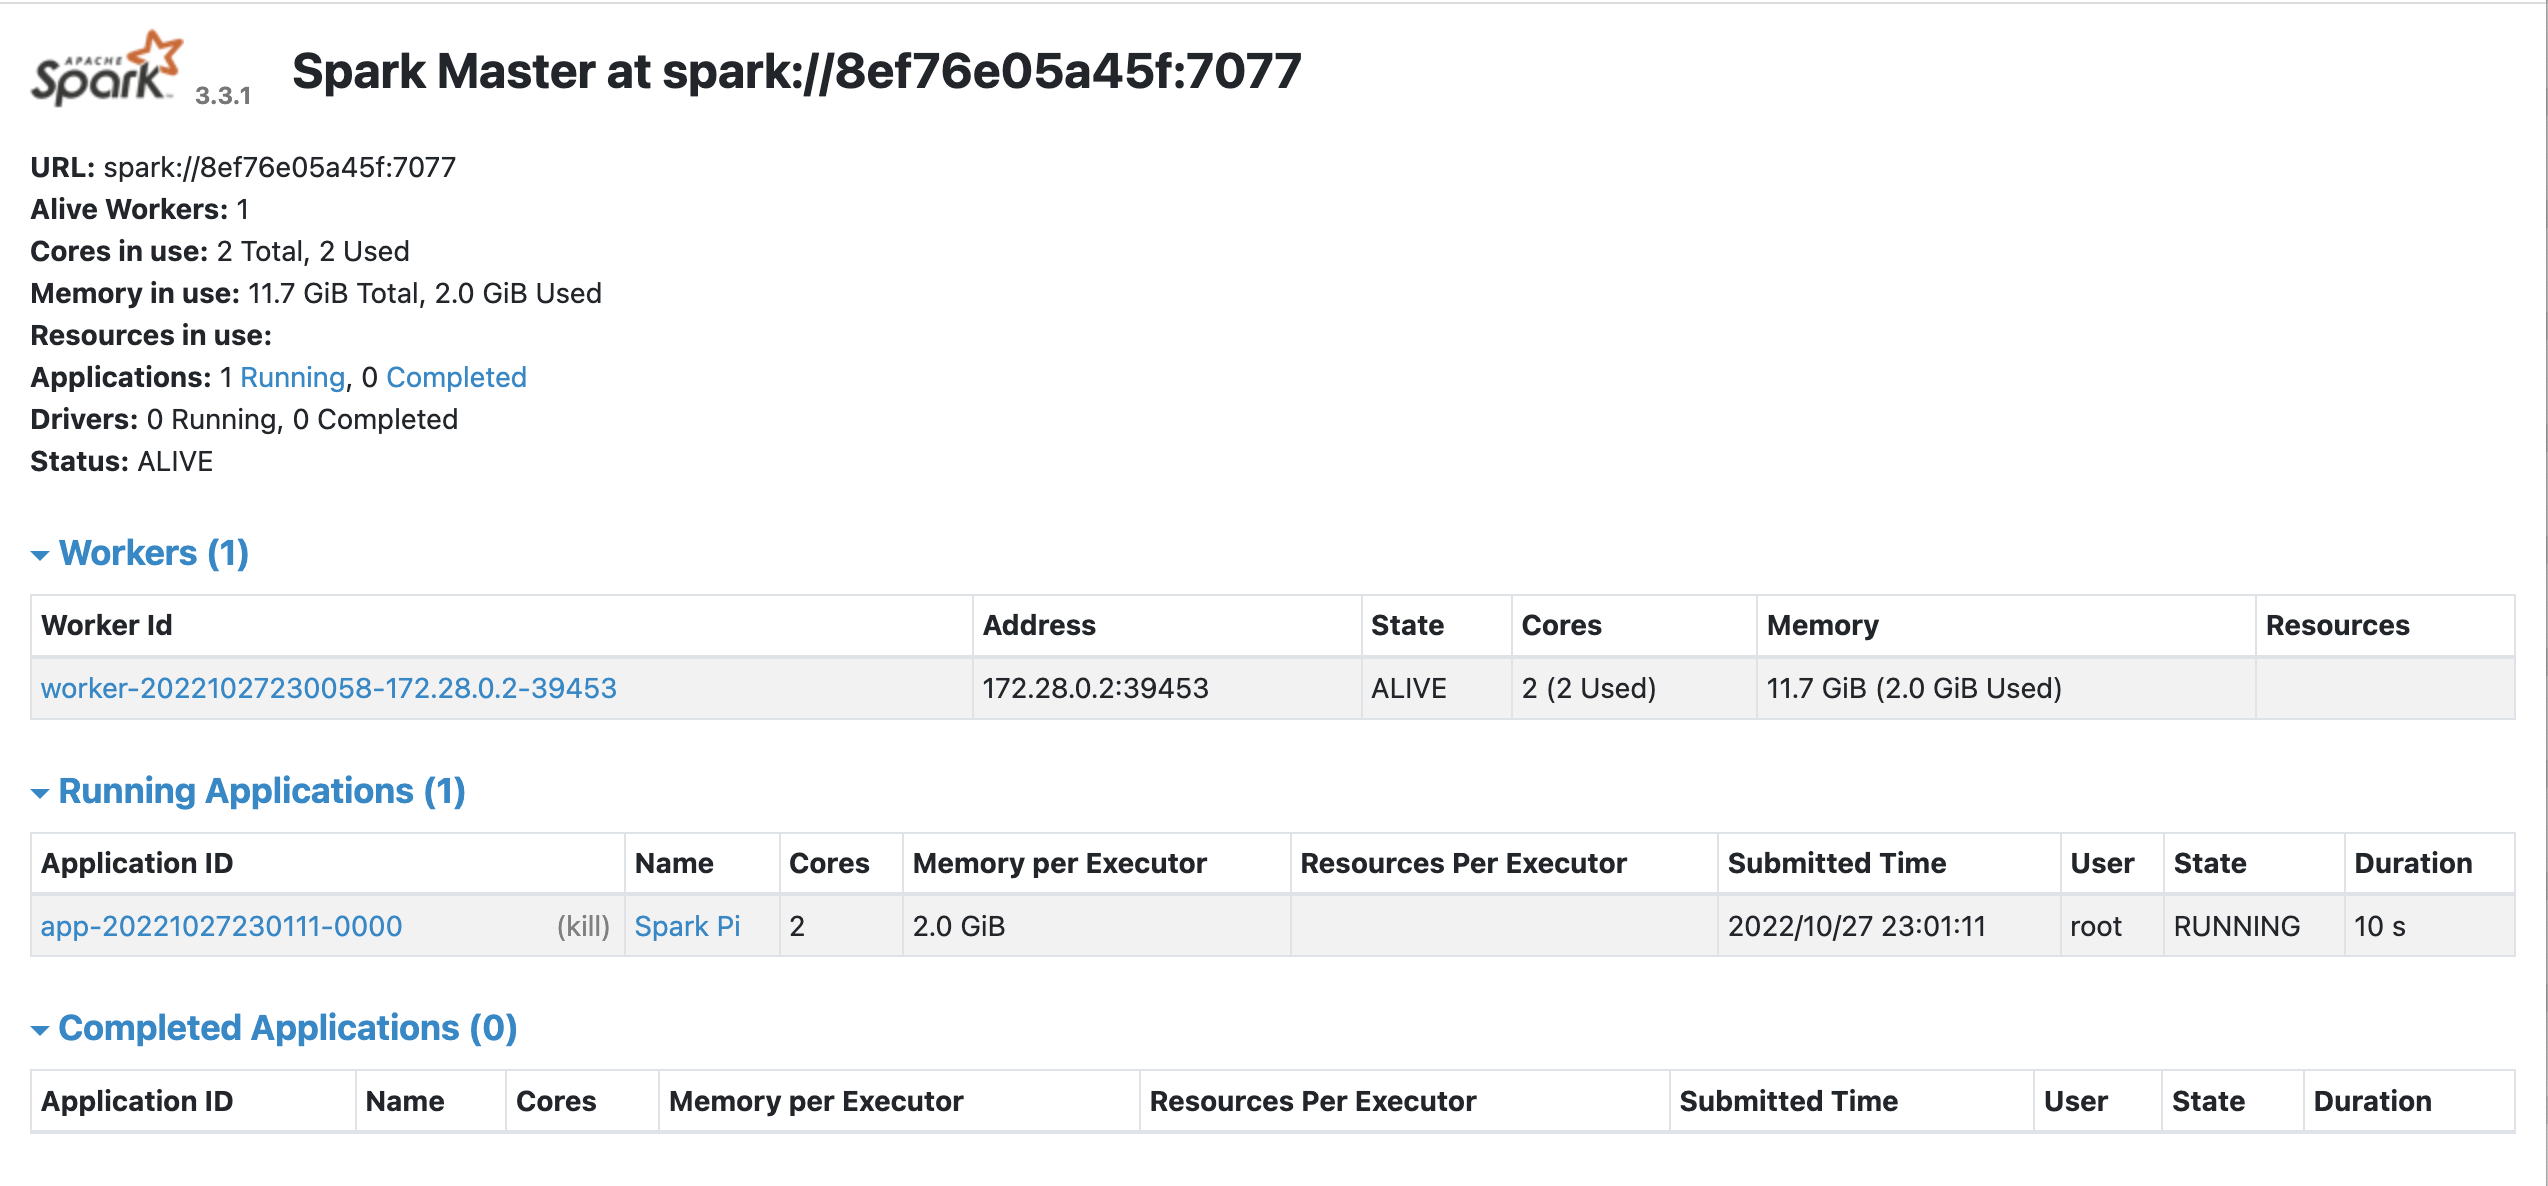

## Start the History Server

If you want to be able to look at the application's UI after its completion, you need to activate Spark's History Server.

The History server can be started with the command:

In [ ]:
%%bash
mkdir -p /tmp/spark-events
$SPARK_HOME/sbin/stop-history-server.sh
$SPARK_HOME/sbin/start-history-server.sh

no org.apache.spark.deploy.history.HistoryServer to stop
starting org.apache.spark.deploy.history.HistoryServer, logging to /content/spark-3.5.0-bin-hadoop3/logs/spark--org.apache.spark.deploy.history.HistoryServer-1-aea6117b4945.out


**Note:** before starting the history server we need to make sure that the directory where the server writes logs exists. The default directory is `file:/tmp/spark-events` (it can be configured by changing the value of the property `spark.history.fs.logDirectory`⸺see [spark-history-server-configuration-options](https://spark.apache.org/docs/latest/monitoring.html#spark-history-server-configuration-options)).

We are not changing the default value of `spark.history.fs.logDirectory` in the Spark configuration but we need to make sure that `/tmp/spark-events` exists. The command `mkdir -p` creates the directory if it does not already exist.

The directory `/tmp/spark-events` containing the logs for the History Server should be empty at this point (if you're running the notebook for the first time).

In [ ]:
!ls /tmp/spark-events

The History Server should now be running behind port $18080$.

Open the History Server in a new window or tab in your browser by clicking on the link below:

In [ ]:
# from google.colab import output
output.serve_kernel_port_as_window(18080)

<IPython.core.display.Javascript object>

If you click on the History Server's link you should see the message
```
 No completed applications found!
```

Let us run the `SparkPi` application once again with just one modification, namely the line:
```
--conf spark.eventLog.enabled=true
```
This tells `spark-submit` that the Spark application should log events.

Since we have not modified the default log directory, we do not need to specify where the application should write logs (otherwise we would have needed an extra `--conf spark.eventLog.dir ...`).

Last but not least, the line
```
2>pi.log
```
will write all standard error (`stderr`) to the file `pi.log` and not clutter the notebook with logging messages as before.

In [ ]:
%%bash

export EXAMPLES_JAR=$(find $SPARK_HOME/examples/jars/ -name "spark-examples_2*")

$SPARK_HOME/bin/spark-submit \
  --class org.apache.spark.examples.SparkPi \
  --master spark://${HOSTNAME}:7077 \
  --conf spark.eventLog.enabled=true \
  $EXAMPLES_JAR \
  100 \
  2>pi.err

Pi is roughly 3.1410555141055516


After completion of the application the History Server tab should look something like this:
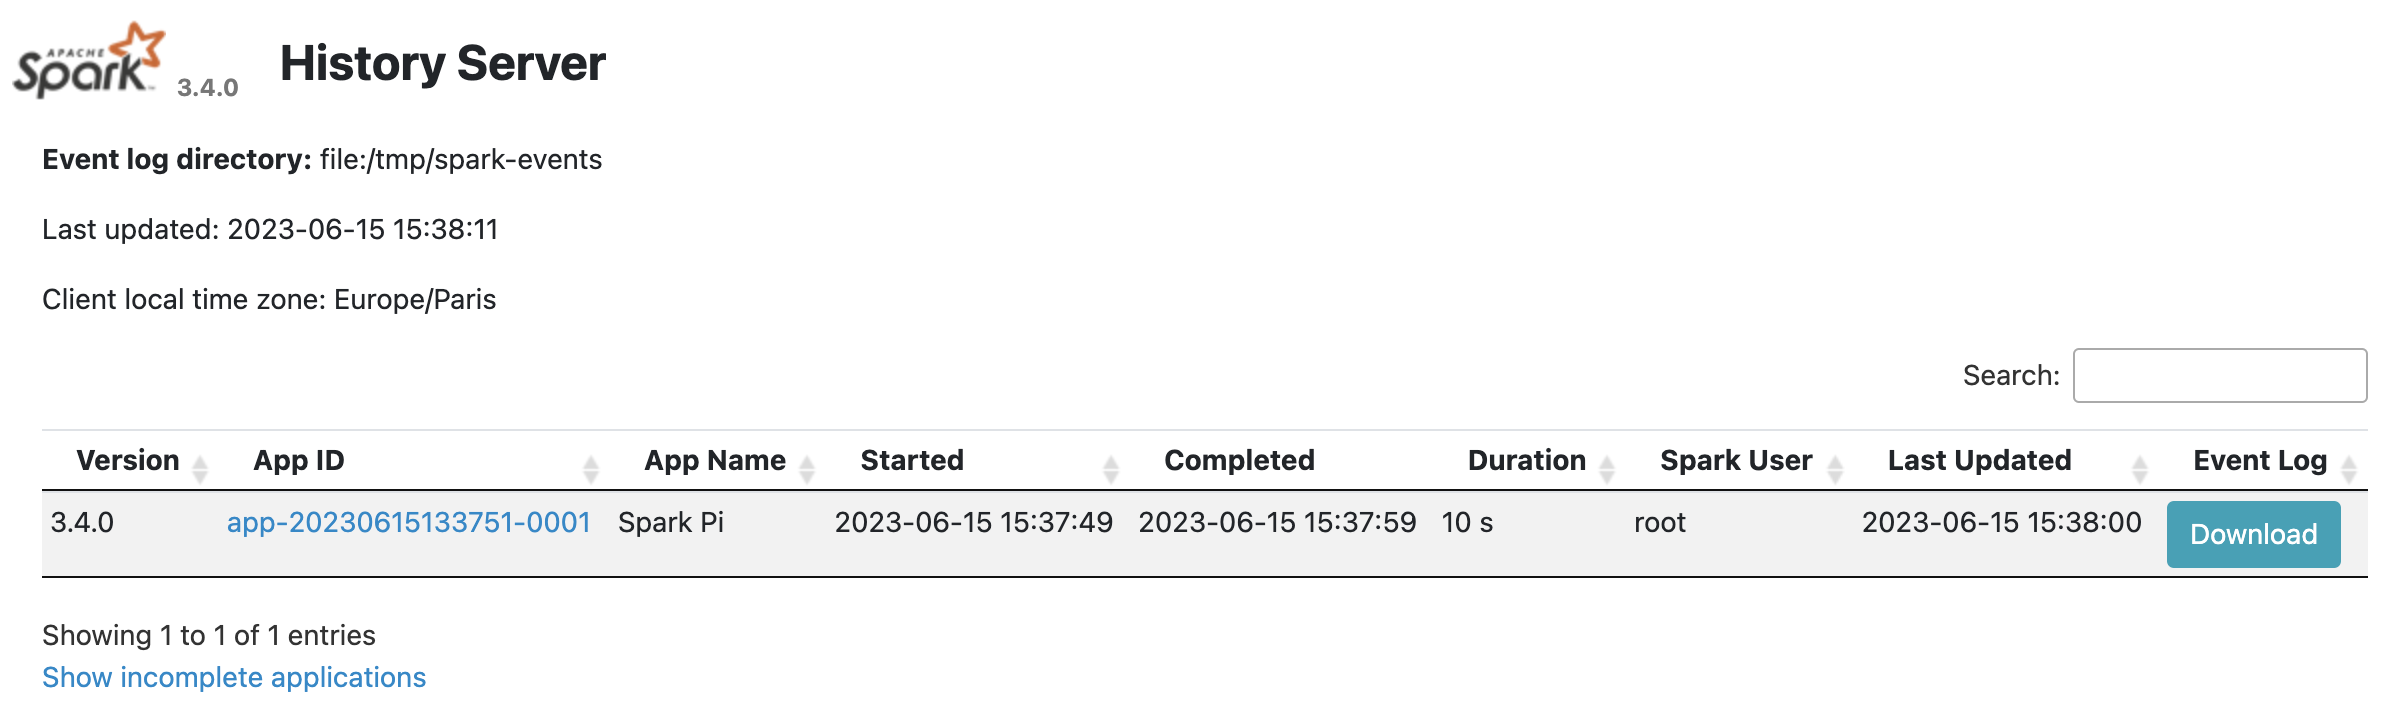

I'm not sure why if you click on the App ID you initially get an error. Just click on it once again the application's UI should appear.

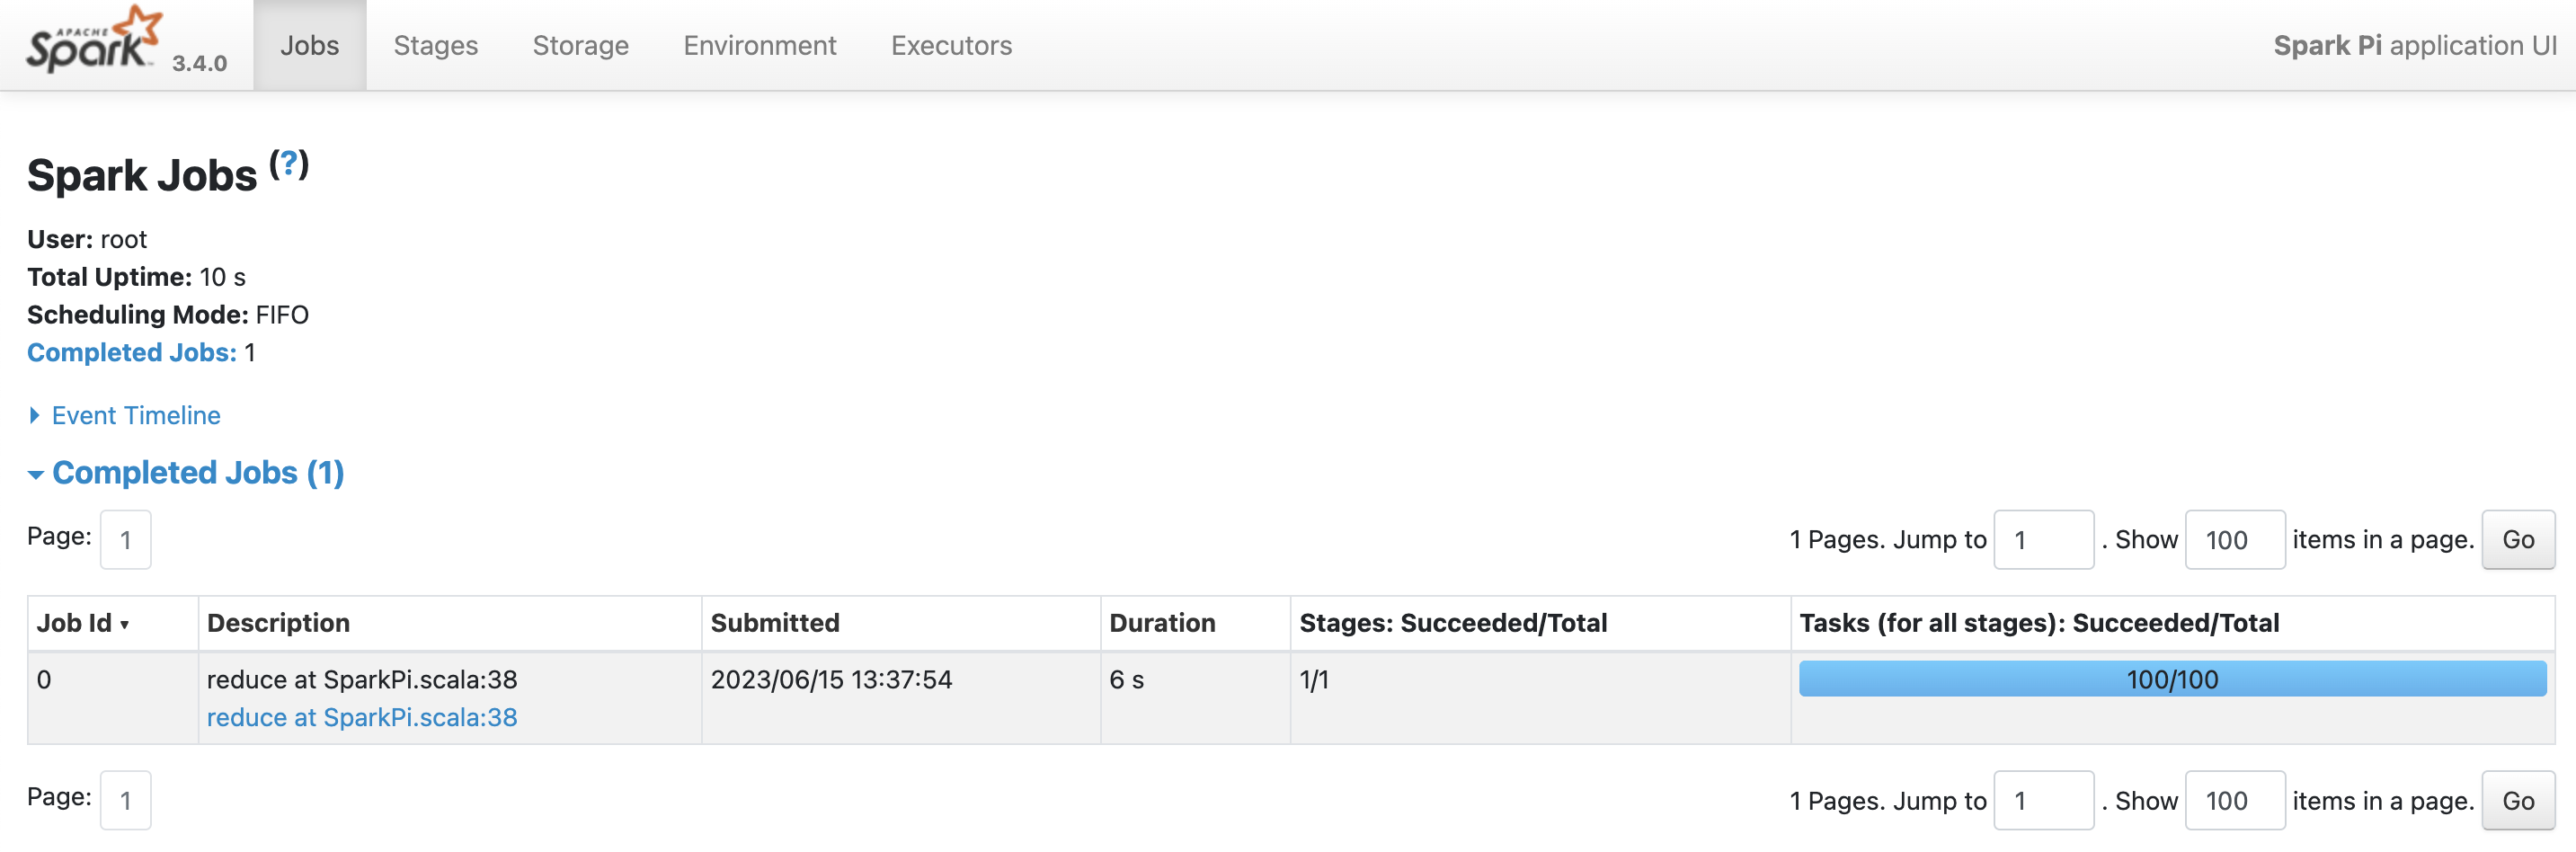

If you click on "reduce at SparkPi..." you get a list of all tasks spawned by the application.

## Shutdown

Shut down all services to free resources.

In [ ]:
%%bash
$SPARK_HOME/sbin/stop-history-server.sh
$SPARK_HOME/sbin/stop-master.sh
$SPARK_HOME/sbin/stop-worker.sh

stopping org.apache.spark.deploy.history.HistoryServer
stopping org.apache.spark.deploy.master.Master
stopping org.apache.spark.deploy.worker.Worker


**Note:** alternatively we could have also used
```
$SPARK_HOME/sbin/stop-all.sh
```
to stop all running services.